--- Step 1: Loading and Merging Data ---
Attempting to load data from: /ssd3/chunlin/smp_video_2025/train_data_combined/cleaned_data.json
Loaded 4000 records from /ssd3/chunlin/smp_video_2025/train_data_combined/cleaned_data.json. Shape: (4000, 22)
Attempting to load data from: /ssd3/chunlin/smp_video_2025/test_data_combined/cleaned_data.json
Loaded 2000 records from /ssd3/chunlin/smp_video_2025/test_data_combined/cleaned_data.json. Shape: (2000, 22)

Loading Captions...
Attempting to load data from: /ssd3/cheng/SMP2025/caption_category.json
Loaded 4000 records from /ssd3/cheng/SMP2025/caption_category.json. Shape: (4000, 4)
Created caption map ('caption'): 4000 unique VIDs.
Attempting to load data from: /ssd3/cheng/SMP2025/caption_shortcaption.json
Loaded 4000 records from /ssd3/cheng/SMP2025/caption_shortcaption.json. Shape: (4000, 4)
Created caption map ('caption'): 4000 unique VIDs.
Attempting to load data from: /ssd3/cheng/SMP2025/caption_target.json
Loaded 4000 records from /ssd3

/tmp/ipykernel_1993337/1006253138.py:132: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_tensor = torch.load(feat_path, map_location=torch.device('cpu'))


Vision features processed. Missing/failed: 0 of 6000.
Records with vision features for vision clustering: 6000
Vision feature matrix for clustering: (6000, 768)

--- Step V2: K-Means for Vision Features (K=300) ---
Visual clustering complete.


==================== AUDIO FEATURE ANALYSIS ====================
--- Step A1: Detecting Audio Feature Shape ---


/tmp/ipykernel_1993337/1006253138.py:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(feat_path, map_location=torch.device('cpu'))


Could not determine audio feature shape. Setting default: (512,)
Using audio feature shape: (512,)
--- Step A2: Loading and Pooling Audio Features ---


/tmp/ipykernel_1993337/1006253138.py:211: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw_tensor = torch.load(feat_path, map_location=torch.device('cpu'))


Audio features processed. Missing/failed: 2 of 6000.
Records with audio features for audio clustering: 5998
Audio feature matrix for clustering: (5998, 512)

--- Step A3: K-Means for Audio Features (K=300) ---
Audio clustering complete.


==================== USER PROFILE CLUSTERING ====================
User feature matrix shape: (6000, 5)

--- Step U1: K-Means for User Features (K=300) ---
User profile clustering complete.

--- Preparing for Profiling: Filtering df_analysis for training data source for popularity stats ---
  Number of training samples in df_analysis for pop stats: 4000


==================== PROFILING TEXT CLUSTERS (Popularity Stats from Training Data Only) ====================

Popularity Statistics per Text Cluster (Training Data Only):
                      mean  median  count       std
text_cluster_label                                 
16                  12.260  12.260      1       NaN
50                  11.692  11.580      5  0.914970
268                 11.46

<Figure size 1400x700 with 0 Axes>

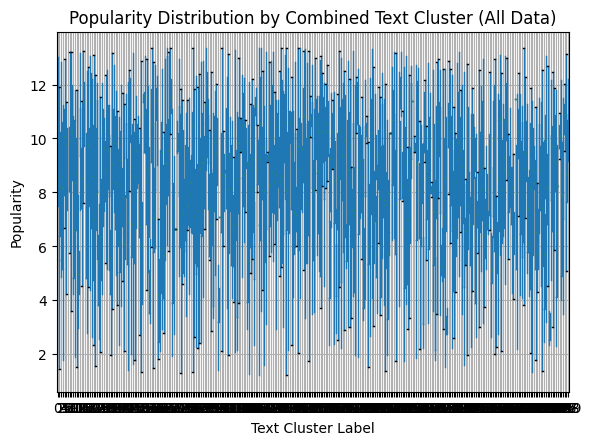

<Figure size 1400x700 with 0 Axes>

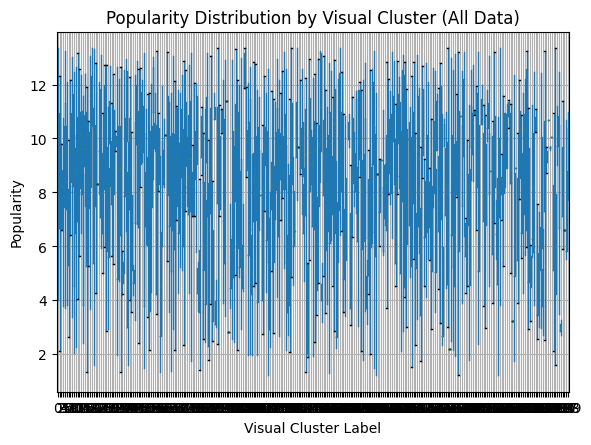

<Figure size 1400x700 with 0 Axes>

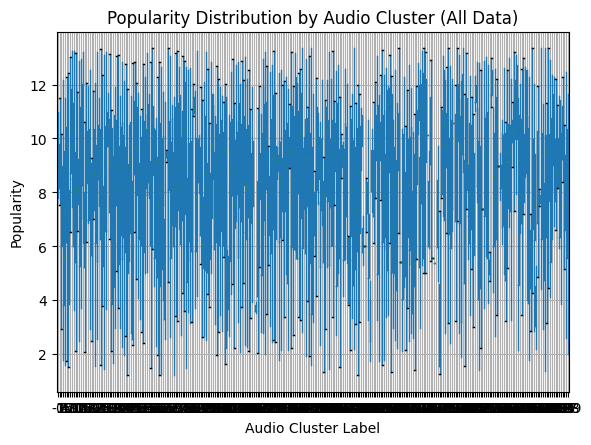

<Figure size 1400x700 with 0 Axes>

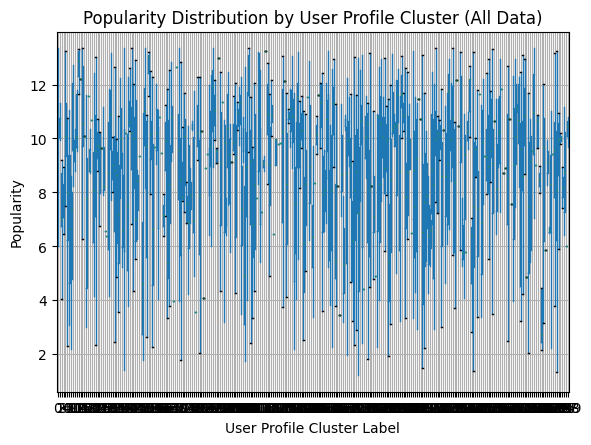

In [1]:
import json
import os
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler # 用於用戶特徵標準化
import matplotlib.pyplot as plt
import re
import torch

# --- User Defined Paths & Constants ---

# 原有數據路徑
TRAIN_MAIN_DATA_PATH = "./processed_data/train_cleaned_data.json"

TRAIN_CAPTION_V4_PATH = "./feature_processing/caption_feature/caption_shortcaption.json"
TRAIN_CAPTION_V3_PATH = "./feature_processing/caption_feature/caption_category.json"
TRAIN_CAPTION_TARGET_PATH = "./feature_processing/caption_feature/caption_target.json"

TEST_MAIN_DATA_PATH = "./processed_data/test_cleaned_data.json"
TEST_CAPTION_V4_PATH = "./feature_processing/caption_feature/captionQ4_test.json"
TEST_CAPTION_V3_PATH = "./feature_processing/caption_feature/captionQ3_test.json"
TEST_CAPTION_Q6_PATH = "./feature_processing/caption_feature/captionQ6_test.json"


# 視覺特徵路徑
TRAIN_VISION_FEAT_DIR_REL = "./feature_processing/video_feature/train"
TEST_VISION_FEAT_DIR_REL = "./feature_processing/video_feature/test"
VISION_FEAT_SHAPE = (256, 768)

FULL_TRAIN_VISION_DIR = TRAIN_VISION_FEAT_DIR_REL
FULL_TEST_VISION_DIR = TEST_VISION_FEAT_DIR_REL

# 新增音頻特徵路徑
TRAIN_AUDIO_FEAT_DIR_REL = "./feature_processing/audio_feature/train"
TEST_AUDIO_FEAT_DIR_REL = "./feature_processing/audio_feature/test"
AUDIO_FEAT_SHAPE = None  # 稍後將動態設置

FULL_TRAIN_AUDIO_DIR = TRAIN_AUDIO_FEAT_DIR_REL
FULL_TEST_AUDIO_DIR = TEST_AUDIO_FEAT_DIR_REL

USER_SPECIFIC_NUMERIC_FEATS = [
    "user_following_count", "user_follower_count",
    "user_likes_count", "user_video_count", "user_digg_count"
]
ALL_NUM_FEATS_FOR_PROFILING = [
    "video_duration", "video_height", "video_width",
    "user_following_count", "user_follower_count",
    "user_likes_count", "user_video_count", "user_digg_count"
]
CATEGORICAL_FEATS_FOR_PROFILING = ['post_location', 'video_ratio', 'dataset_source', 'post_text_language']


def load_json_file_to_df(filepath):
    records = []
    print(f"Attempting to load data from: {filepath}")
    if not os.path.exists(filepath):
        print(f"Error: File not found at {filepath}")
        return pd.DataFrame()
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            first_char = f.read(1); f.seek(0)
            if not first_char: print(f"Warning: File {filepath} is empty."); return pd.DataFrame()
            if first_char == '[': data = json.load(f); records.extend(data) if isinstance(data, list) else print(f"Warning: File {filepath} not a JSON list.")
            else:
                for ln, line in enumerate(f):
                    if line.strip():
                        try: records.append(json.loads(line))
                        except json.JSONDecodeError as e: print(f"Warning: Parse error line {ln+1} in {filepath}: {line[:100]}... Error: {e}")
        df = pd.DataFrame(records)
        print(f"Loaded {len(df)} records from {filepath}. Shape: {df.shape}")
        # Ensure 'pid' is present, if not, try to use 'id' or generate one.
        if 'pid' not in df.columns:
            if 'id' in df.columns: # Common alternative name
                df.rename(columns={'id': 'pid'}, inplace=True)
            else: # Fallback, though not ideal if 'pid' is crucial for original data identity
                print(f"Warning: 'pid' column not found in {filepath}. Results might be affected if 'pid' is a key identifier.")
        return df
    except Exception as e: print(f"Error loading {filepath}: {e}"); return pd.DataFrame()

def convert_caption_df_to_map(df_caption, vid_col='vid', caption_col='caption'):
    if df_caption.empty: return {}
    for col in [vid_col, caption_col]:
        if col not in df_caption.columns: print(f"Warning: Col '{col}' not in caption DF for map. Cols: {df_caption.columns.tolist()}."); return {}
    df_c = df_caption.dropna(subset=[vid_col]).drop_duplicates(subset=[vid_col], keep='first')
    caption_map = pd.Series(df_c[caption_col].fillna('').values, index=df_c[vid_col]).to_dict()
    print(f"Created caption map ('{caption_col}'): {len(caption_map)} unique VIDs.")
    return caption_map

def preprocess_text_for_tfidf(text_series):
    cleaned = []
    for text in text_series:
        if pd.isna(text) or not text: cleaned.append(""); continue
        txt = str(text).replace(',', ' ').lower()
        txt = re.sub(r'[^\w\s]', '', txt)
        txt = re.sub(r'\s+', ' ', txt).strip()
        cleaned.append(txt)
    return cleaned

def _adjust_tensor_shape(tensor, target_shape_tuple):
    if not isinstance(tensor, torch.Tensor):
        try: tensor = torch.tensor(tensor, dtype=torch.float32)
        except Exception as e: print(f"Error converting to tensor in _adjust_tensor_shape: {e}. Zeros."); return torch.zeros(target_shape_tuple, dtype=torch.float32)
    tensor = tensor.to(dtype=torch.float32)
    target_rows, target_cols = target_shape_tuple
    if len(tensor.shape) != 2: return torch.zeros(target_shape_tuple, dtype=torch.float32)
    current_rows, current_cols = tensor.shape
    if current_rows == 0 or current_cols == 0: return torch.zeros(target_shape_tuple, dtype=torch.float32)
    if current_rows > target_rows: tensor = tensor[:target_rows, :]
    elif current_rows < target_rows:
        padding = torch.zeros(target_rows - current_rows, current_cols, dtype=torch.float32, device=tensor.device)
        tensor = torch.cat([tensor, padding], dim=0)
    current_rows, current_cols = tensor.shape
    if current_cols > target_cols: tensor = tensor[:, :target_cols]
    elif current_cols < target_cols:
        padding = torch.zeros(tensor.shape[0], target_cols - current_cols, dtype=torch.float32, device=tensor.device)
        tensor = torch.cat([tensor, padding], dim=1)
    return tensor

def load_and_pool_vision_feature(row, target_shape_tuple, pooling_strategy='mean'):
    uid, vid, dataset_src = row.get('uid'), row.get('vid'), row.get('dataset_source')
    if any(pd.isna(x) for x in [uid, vid, dataset_src]): return None
    rel_vision_dir = TRAIN_VISION_FEAT_DIR_REL if dataset_src == 'train' else TEST_VISION_FEAT_DIR_REL
    feat_path = os.path.join(rel_vision_dir, f"{uid}_{vid}.pt")
    if not os.path.exists(feat_path): return None
    try:
        raw_tensor = torch.load(feat_path, map_location=torch.device('cpu'))
        if not isinstance(raw_tensor, torch.Tensor):
            if isinstance(raw_tensor, dict) and 'last_hidden_state' in raw_tensor: raw_tensor = raw_tensor['last_hidden_state']
            elif isinstance(raw_tensor, dict) and len(raw_tensor) > 0:
                for val in raw_tensor.values():
                    if isinstance(val, torch.Tensor): raw_tensor = val; break
            if not isinstance(raw_tensor, torch.Tensor): print(f"Warn: {feat_path} not tensor/dict (type: {type(raw_tensor)}). Skip."); return None
        if raw_tensor.ndim > 2 and raw_tensor.shape[0] == 1: raw_tensor = raw_tensor.squeeze(0)
        elif raw_tensor.ndim == 1 and raw_tensor.shape[0] == target_shape_tuple[0] * target_shape_tuple[1]:
                 raw_tensor = raw_tensor.view(target_shape_tuple[0], target_shape_tuple[1])
        adjusted_tensor = _adjust_tensor_shape(raw_tensor, target_shape_tuple)
        if adjusted_tensor.shape == target_shape_tuple:
            if pooling_strategy == 'mean': pooled_vector = adjusted_tensor.mean(dim=0)
            elif pooling_strategy == 'max': pooled_vector = adjusted_tensor.max(dim=0).values
            elif pooling_strategy == 'cls_token': pooled_vector = adjusted_tensor[0, :]
            else: pooled_vector = adjusted_tensor.mean(dim=0) # Default to mean
            return pooled_vector.numpy()
        return None
    except Exception as e: print(f"Error processing vision {feat_path}: {e}"); return None

def determine_audio_feature_shape():
    """確定音頻特徵的形狀"""
    global AUDIO_FEAT_SHAPE
    
    # 遍歷訓練目錄尋找第一個有效的音頻特徵文件
    if os.path.exists(FULL_TRAIN_AUDIO_DIR):
        for f in os.listdir(FULL_TRAIN_AUDIO_DIR):
            if f.endswith('.pt'):
                try:
                    feat_path = os.path.join(FULL_TRAIN_AUDIO_DIR, f)
                    tensor = torch.load(feat_path, map_location=torch.device('cpu'))
                    if isinstance(tensor, torch.Tensor):
                        if tensor.ndim == 2:
                            AUDIO_FEAT_SHAPE = tensor.shape
                            print(f"Detected audio feature shape: {AUDIO_FEAT_SHAPE}")
                            return AUDIO_FEAT_SHAPE
                        elif tensor.ndim > 2 and tensor.shape[1] > 0 and tensor.shape[2] > 0:
                            AUDIO_FEAT_SHAPE = (tensor.shape[1], tensor.shape[2])
                            print(f"Detected and adjusted audio feature shape from {tensor.shape} to {AUDIO_FEAT_SHAPE}")
                            return AUDIO_FEAT_SHAPE
                    elif isinstance(tensor, dict) and len(tensor) > 0:
                        for key, val in tensor.items():
                            if isinstance(val, torch.Tensor) and val.ndim >= 2:
                                if val.ndim == 2:
                                    AUDIO_FEAT_SHAPE = val.shape
                                else:
                                    AUDIO_FEAT_SHAPE = (val.shape[1], val.shape[2]) if val.ndim > 2 else val.shape
                                print(f"Detected audio feature shape from dict[{key}]: {AUDIO_FEAT_SHAPE}")
                                return AUDIO_FEAT_SHAPE
                except Exception as e:
                    print(f"Error examining audio feature file {f}: {e}")
                    continue
    
    # 如果找不到有效的音頻特徵，設置一個默認的形狀
    if AUDIO_FEAT_SHAPE is None:
        AUDIO_FEAT_SHAPE = (512,)  # 改為1維
        print(f"Could not determine audio feature shape. Setting default: {AUDIO_FEAT_SHAPE}")
    
    return AUDIO_FEAT_SHAPE

def load_and_pool_audio_feature(row, target_shape_tuple=None, pooling_strategy='mean'):
    """加載和處理音頻特徵，類似於視覺特徵處理邏輯"""
    global AUDIO_FEAT_SHAPE
    
    # 如果還沒確定音頻特徵形狀，先確定
    if target_shape_tuple is None:
        if AUDIO_FEAT_SHAPE is None:
            AUDIO_FEAT_SHAPE = determine_audio_feature_shape()
        target_shape_tuple = AUDIO_FEAT_SHAPE
    
    uid, vid, dataset_src = row.get('uid'), row.get('vid'), row.get('dataset_source')
    if any(pd.isna(x) for x in [uid, vid, dataset_src]): return None
    
    rel_audio_dir = TRAIN_AUDIO_FEAT_DIR_REL if dataset_src == 'train' else TEST_AUDIO_FEAT_DIR_REL
    feat_path = os.path.join(rel_audio_dir, f"{uid}_{vid}.pt")
    
    if not os.path.exists(feat_path): return None
    
    try:
        raw_tensor = torch.load(feat_path, map_location=torch.device('cpu'))
        if not isinstance(raw_tensor, torch.Tensor):
            if isinstance(raw_tensor, dict) and len(raw_tensor) > 0:
                # 嘗試尋找字典中的張量
                for key_name in ['audio_features', 'audio_embeddings', 'features', 'embeddings', 'last_hidden_state']:
                    if key_name in raw_tensor and isinstance(raw_tensor[key_name], torch.Tensor):
                        raw_tensor = raw_tensor[key_name]
                        break
                # 如果沒有找到預期的鍵，嘗試使用第一個張量值
                if not isinstance(raw_tensor, torch.Tensor):
                    for val in raw_tensor.values():
                        if isinstance(val, torch.Tensor):
                            raw_tensor = val
                            break
            # 如果經過上述處理後還不是張量，則返回 None
            if not isinstance(raw_tensor, torch.Tensor):
                print(f"Warn: {feat_path} audio not tensor/dict (type: {type(raw_tensor)}). Skip.")
                return None
        
        # 🔧 關鍵修改：正確處理1維音頻特徵
        if raw_tensor.ndim == 1:
            # 1維特徵，直接返回（這是音頻特徵的正常情況）
            if len(target_shape_tuple) == 1 and raw_tensor.shape[0] == target_shape_tuple[0]:
                return raw_tensor.numpy()
            elif len(target_shape_tuple) == 1:
                # 如果維度不匹配，進行調整
                target_dim = target_shape_tuple[0]
                if raw_tensor.shape[0] > target_dim:
                    # 截斷
                    return raw_tensor[:target_dim].numpy()
                else:
                    # 補零
                    padded = torch.zeros(target_dim)
                    padded[:raw_tensor.shape[0]] = raw_tensor
                    return padded.numpy()
            else:
                # 如果目標是2維，但音頻是1維，直接返回1維
                return raw_tensor.numpy()
        
        elif raw_tensor.ndim == 2:
            # 2維特徵，需要池化
            if pooling_strategy == 'mean': 
                pooled_vector = raw_tensor.mean(dim=0)
            elif pooling_strategy == 'max': 
                pooled_vector = raw_tensor.max(dim=0).values
            elif pooling_strategy == 'cls_token': 
                pooled_vector = raw_tensor[0, :]
            else: 
                pooled_vector = raw_tensor.mean(dim=0)
            
            return pooled_vector.numpy()
        
        elif raw_tensor.ndim > 2:
            # 高維特徵，先降維再處理
            if raw_tensor.shape[0] == 1: 
                raw_tensor = raw_tensor.squeeze(0)
                # 遞歸調用自己處理降維後的張量
                temp_row = {'uid': uid, 'vid': vid, 'dataset_source': dataset_src}
                return load_and_pool_audio_feature(temp_row, target_shape_tuple, pooling_strategy)
            else:
                # 多維特徵，取平均
                while raw_tensor.ndim > 1:
                    raw_tensor = raw_tensor.mean(dim=0)
                return raw_tensor.numpy()
        
        else:
            print(f"Warn: Unsupported audio tensor dimension: {raw_tensor.shape}")
            return None
        
    except Exception as e: 
        print(f"Error processing audio {feat_path}: {e}")
        return None

# --- Main Analysis Script ---
if __name__ == "__main__":
    print("--- Step 1: Loading and Merging Data ---")
    df_train_main = load_json_file_to_df(TRAIN_MAIN_DATA_PATH)
    df_test_main = load_json_file_to_df(TEST_MAIN_DATA_PATH)

    if not df_train_main.empty: df_train_main['dataset_source'] = 'train'
    if not df_test_main.empty: df_test_main['dataset_source'] = 'test'
    
    # Ensure 'pid' exists before concatenation if it's critical
    if 'pid' not in df_train_main.columns and not df_train_main.empty:
        print("CRITICAL WARNING: 'pid' missing in TRAIN data. CSV export might fail or be incorrect.")
    if 'pid' not in df_test_main.columns and not df_test_main.empty:
        print("CRITICAL WARNING: 'pid' missing in TEST data. CSV export might fail or be incorrect.")

    df_all_main = pd.concat([df_train_main, df_test_main], ignore_index=True).reset_index(drop=True)

    if df_all_main.empty: print("Error: No main data loaded. Exiting."); exit()
    if 'pid' not in df_all_main.columns:
        print("CRITICAL ERROR: 'pid' column is missing from df_all_main after concatenation. Exiting.")
        exit()

    print("\nLoading Captions...")
    # 原有 captions
    train_captions_v3_map = convert_caption_df_to_map(load_json_file_to_df(TRAIN_CAPTION_V3_PATH), vid_col='vid', caption_col='caption')
    train_captions_v4_map = convert_caption_df_to_map(load_json_file_to_df(TRAIN_CAPTION_V4_PATH), vid_col='vid', caption_col='caption')
    train_captions_target_map = convert_caption_df_to_map(load_json_file_to_df(TRAIN_CAPTION_TARGET_PATH), vid_col='vid', caption_col='caption')
    test_captions_v3_map = convert_caption_df_to_map(load_json_file_to_df(TEST_CAPTION_V3_PATH), vid_col='vid', caption_col='caption')
    test_captions_v4_map = convert_caption_df_to_map(load_json_file_to_df(TEST_CAPTION_V4_PATH), vid_col='vid', caption_col='caption')    
    test_captions_q6_map = convert_caption_df_to_map(load_json_file_to_df(TEST_CAPTION_Q6_PATH), vid_col='vid', caption_col='caption')

    if 'vid' in df_all_main.columns:
        # 添加原有 captions
        df_all_main['caption_v3'] = df_all_main.apply(lambda r: train_captions_v3_map.get(r['vid'], '') if r['dataset_source'] == 'train' else test_captions_v3_map.get(r['vid'], ''), axis=1)
        df_all_main['caption_v4'] = df_all_main.apply(lambda r: train_captions_v4_map.get(r['vid'], '') if r['dataset_source'] == 'train' else test_captions_v4_map.get(r['vid'], ''), axis=1)
        
        # 添加新增 captions
        df_all_main['caption_target'] = df_all_main.apply(lambda r: train_captions_target_map.get(r['vid'], '') if r['dataset_source'] == 'train' else test_captions_q6_map.get(r['vid'], ''), axis=1)
    else: 
        print("Warning: 'vid' column missing. Captions empty.")
        df_all_main['caption_v3'] = ''
        df_all_main['caption_v4'] = ''
        df_all_main['caption_target'] = ''

    # 修改文本組合函數，包含新的caption_target
    def combine_text_for_row(row):
        return " ".join([str(t) for t in [row.get('post_content'), row.get('caption_v3'), 
                                          row.get('caption_v4'), row.get('caption_target')] 
                         if pd.notna(t) and str(t).strip()]) or ""
    
    df_all_main['text_for_clustering'] = df_all_main.apply(combine_text_for_row, axis=1)

    if 'popularity' in df_all_main.columns:
        df_all_main['popularity_numeric'] = pd.to_numeric(df_all_main['popularity'], errors='coerce')
    else:
        print("Warning: 'popularity' column not found. Pop-based profiling will be skipped or show NaNs.")
        df_all_main['popularity_numeric'] = np.nan

    df_analysis = df_all_main.copy() # df_analysis will have 'pid' from df_all_main
    for feature in ALL_NUM_FEATS_FOR_PROFILING:
        if feature in df_analysis.columns:
            df_analysis[feature] = pd.to_numeric(df_analysis[feature], errors='coerce')
        else: df_analysis[feature] = np.nan

    df_text_clustering_input = df_analysis[df_analysis['text_for_clustering'].str.strip().astype(bool) & (df_analysis['text_for_clustering'].str.strip() != '')].copy()

    print(f"\nTotal records in df_analysis (base for all clustering types): {len(df_analysis)}")
    print(f"  Records with valid text for text clustering: {len(df_text_clustering_input)}")
    print(f"  Popularity in df_analysis: {df_analysis['popularity_numeric'].notna().sum()} valid, {df_analysis['popularity_numeric'].isna().sum()} missing.")
    non_nan_popularity_count = df_analysis['popularity_numeric'].notna().sum()
    if non_nan_popularity_count == 0 and len(df_analysis) > 0:
        print("CRITICAL WARNING! All 'popularity_numeric' values are NaN in df_analysis. All popularity stats (mean, median, std) for clusters will be NaN or 0.")
    elif len(df_analysis) > 0 and non_nan_popularity_count > 0 :
        print(f"  'popularity_numeric' descriptive stats (based on {non_nan_popularity_count} valid values in df_analysis):")
        print(df_analysis['popularity_numeric'].describe())

    # --- 文本聚類處理 ---
    text_clusters_assigned = False; text_svd_model = None; text_n_comp_svd = 0; text_kmeans = None; text_n_clusters = 0
    if not df_text_clustering_input.empty:
        print("\n--- Step T2: Preprocessing Combined Text for Text Clustering ---")
        df_text_clustering_input.loc[:, 'processed_content'] = preprocess_text_for_tfidf(df_text_clustering_input['text_for_clustering'])
        print("\n--- Step T3: TF-IDF for Text Clustering ---")
        vectorizer = TfidfVectorizer(max_features=2000, stop_words='english', min_df=5, max_df=0.7)
        tfidf_matrix = vectorizer.fit_transform(df_text_clustering_input['processed_content'])
        print(f"Text TF-IDF matrix shape: {tfidf_matrix.shape}")
        if tfidf_matrix.shape[0] > 0 and tfidf_matrix.shape[1] > 0 :
            text_s_svd, text_f_svd = tfidf_matrix.shape
            if text_f_svd > 1 and text_s_svd > 1: text_n_comp_svd = min(100, text_f_svd - 1, text_s_svd - 1)
            text_reduced_matrix = tfidf_matrix
            if text_n_comp_svd > 0:
                print(f"\n--- Step T4: SVD for Text (to {text_n_comp_svd} components) ---")
                text_svd_model = TruncatedSVD(n_components=text_n_comp_svd, random_state=42)
                text_reduced_matrix = text_svd_model.fit_transform(tfidf_matrix)
            else: print(f"\n--- Step T4: Skipping SVD for Text ---")
            text_n_clusters = 300 # Reduced for testing, was 100
            if text_reduced_matrix.shape[0] < text_n_clusters: text_n_clusters = max(1, text_reduced_matrix.shape[0])
            if text_n_clusters > 0 and text_reduced_matrix.shape[0] >= text_n_clusters:
                print(f"\n--- Step T5: K-Means for Text (K={text_n_clusters}) ---")
                text_kmeans = KMeans(n_clusters=text_n_clusters, random_state=42, n_init='auto')
                try:
                    df_text_clustering_input.loc[:, 'text_cluster_label'] = text_kmeans.fit_predict(text_reduced_matrix)
                    text_clusters_assigned = True; print("Text clustering complete.")
                    # Merge back to df_analysis using the index (which should align)
                    df_analysis = df_analysis.merge(df_text_clustering_input[['text_cluster_label']], left_index=True, right_index=True, how='left', suffixes=('', '_text_cl_temp'))
                    if 'text_cluster_label_text_cl_temp' in df_analysis.columns:
                         df_analysis['text_cluster_label'] = df_analysis['text_cluster_label_text_cl_temp']
                         df_analysis.drop(columns=['text_cluster_label_text_cl_temp'], inplace=True)
                    if 'text_cluster_label' in df_analysis.columns: df_analysis['text_cluster_label'] = df_analysis['text_cluster_label'].fillna(-1).astype(int)
                except Exception as e: print(f"Error in Text K-Means: {e}")
            else: print("Skipping Text K-Means.")
        else: print("Error: Text TF-IDF matrix empty. Skipping text clustering.")
    else: print("Skipping text clustering: no valid text data.")
    if 'text_cluster_label' not in df_analysis.columns: df_analysis['text_cluster_label'] = -1

    # --- 視覺特徵分析 ---
    print("\n\n" + "="*20 + " VISION FEATURE ANALYSIS " + "="*20)
    print("--- Step V1: Loading and Pooling Vision Features ---")
    df_analysis['vision_feature_vector'] = df_analysis.apply(
        lambda row: load_and_pool_vision_feature(row, VISION_FEAT_SHAPE, pooling_strategy='mean'), axis=1)
    missing_vision_count = df_analysis['vision_feature_vector'].isna().sum()
    print(f"Vision features processed. Missing/failed: {missing_vision_count} of {len(df_analysis)}.")
    df_vision_clustering_input = df_analysis.dropna(subset=['vision_feature_vector']).copy()
    print(f"Records with vision features for vision clustering: {len(df_vision_clustering_input)}")
    visual_clusters_assigned = False; vis_kmeans = None; vis_n_clusters = 0
    if not df_vision_clustering_input.empty and len(df_vision_clustering_input) > 1 :
        vision_feature_matrix = np.vstack(df_vision_clustering_input['vision_feature_vector'].values)
        print(f"Vision feature matrix for clustering: {vision_feature_matrix.shape}")
        vis_n_clusters = 300 # Reduced for testing, was 100
        if vision_feature_matrix.shape[0] < vis_n_clusters: vis_n_clusters = max(1, vision_feature_matrix.shape[0])
        if vis_n_clusters > 0 and vision_feature_matrix.shape[0] >= vis_n_clusters:
            print(f"\n--- Step V2: K-Means for Vision Features (K={vis_n_clusters}) ---")
            vis_kmeans = KMeans(n_clusters=vis_n_clusters, random_state=42, n_init='auto')
            try:
                df_vision_clustering_input.loc[:, 'visual_cluster_label'] = vis_kmeans.fit_predict(vision_feature_matrix)
                visual_clusters_assigned = True; print("Visual clustering complete.")
                df_analysis = df_analysis.merge(df_vision_clustering_input[['visual_cluster_label']], left_index=True, right_index=True, how='left', suffixes=('', '_vis_cl_temp'))
                if 'visual_cluster_label_vis_cl_temp' in df_analysis.columns:
                    df_analysis['visual_cluster_label'] = df_analysis['visual_cluster_label_vis_cl_temp']
                    df_analysis.drop(columns=['visual_cluster_label_vis_cl_temp'], inplace=True)
                if 'visual_cluster_label' in df_analysis.columns: df_analysis['visual_cluster_label'] = df_analysis['visual_cluster_label'].fillna(-1).astype(int)
            except Exception as e: print(f"Error in Visual K-Means: {e}")
        else: print("Skipping Visual K-Means.")
    else: print("\nSkipping vision feature clustering.")
    if 'visual_cluster_label' not in df_analysis.columns: df_analysis['visual_cluster_label'] = -1

    # --- 新增的音頻特徵分析 ---
    print("\n\n" + "="*20 + " AUDIO FEATURE ANALYSIS " + "="*20)
    print("--- Step A1: Detecting Audio Feature Shape ---")
    # 檢測音頻特徵的形狀
    audio_feat_shape = determine_audio_feature_shape()
    print(f"Using audio feature shape: {audio_feat_shape}")
   
    print("--- Step A2: Loading and Pooling Audio Features ---")
    df_analysis['audio_feature_vector'] = df_analysis.apply(
        lambda row: load_and_pool_audio_feature(row, audio_feat_shape, pooling_strategy='mean'), axis=1)
    missing_audio_count = df_analysis['audio_feature_vector'].isna().sum()
    print(f"Audio features processed. Missing/failed: {missing_audio_count} of {len(df_analysis)}.")
    df_audio_clustering_input = df_analysis.dropna(subset=['audio_feature_vector']).copy()
    print(f"Records with audio features for audio clustering: {len(df_audio_clustering_input)}")
   
    audio_clusters_assigned = False; audio_kmeans = None; audio_n_clusters = 0
    if not df_audio_clustering_input.empty and len(df_audio_clustering_input) > 1 :
        try:
            audio_feature_matrix = np.vstack(df_audio_clustering_input['audio_feature_vector'].values)
            print(f"Audio feature matrix for clustering: {audio_feature_matrix.shape}")
            audio_n_clusters = 300  # 與其他特徵保持一致
            if audio_feature_matrix.shape[0] < audio_n_clusters: 
                audio_n_clusters = max(1, audio_feature_matrix.shape[0])
           
            if audio_n_clusters > 0 and audio_feature_matrix.shape[0] >= audio_n_clusters:
                print(f"\n--- Step A3: K-Means for Audio Features (K={audio_n_clusters}) ---")
                audio_kmeans = KMeans(n_clusters=audio_n_clusters, random_state=42, n_init='auto')
                try:
                    df_audio_clustering_input.loc[:, 'audio_cluster_label'] = audio_kmeans.fit_predict(audio_feature_matrix)
                    audio_clusters_assigned = True; print("Audio clustering complete.")
                    df_analysis = df_analysis.merge(df_audio_clustering_input[['audio_cluster_label']], 
                                                    left_index=True, right_index=True, 
                                                    how='left', suffixes=('', '_audio_cl_temp'))
                    if 'audio_cluster_label_audio_cl_temp' in df_analysis.columns:
                        df_analysis['audio_cluster_label'] = df_analysis['audio_cluster_label_audio_cl_temp']
                        df_analysis.drop(columns=['audio_cluster_label_audio_cl_temp'], inplace=True)
                    if 'audio_cluster_label' in df_analysis.columns: 
                        df_analysis['audio_cluster_label'] = df_analysis['audio_cluster_label'].fillna(-1).astype(int)
                except Exception as e: 
                    print(f"Error in Audio K-Means: {e}")
            else: 
                print("Skipping Audio K-Means.")
        except Exception as e:
            print(f"Error preparing audio feature matrix: {e}")
    else: 
        print("\nSkipping audio feature clustering: insufficient data.")
   
    if 'audio_cluster_label' not in df_analysis.columns: 
        df_analysis['audio_cluster_label'] = -1

    # --- 用戶分析 ---
    print("\n\n" + "="*20 + " USER PROFILE CLUSTERING " + "="*20)
    df_user_clustering_input = df_analysis.copy()
    valid_user_features_for_clustering = []
    for feature in USER_SPECIFIC_NUMERIC_FEATS:
        if feature in df_user_clustering_input.columns:
            if df_user_clustering_input[feature].notna().sum() < 0.1 * len(df_user_clustering_input): print(f"Warning: User feature '{feature}' has >90% NaN values.")
            median_val = df_user_clustering_input[feature].median()
            if pd.isna(median_val): median_val = 0; print(f"Warning: Median for '{feature}' is NaN, filling with 0.")
            df_user_clustering_input.loc[:, feature] = df_user_clustering_input[feature].fillna(median_val)
            valid_user_features_for_clustering.append(feature)
        else: print(f"Warning: User feature '{feature}' not found.")
    user_clusters_assigned = False; user_kmeans_model = None; user_n_clusters = 0; scaler_user = None
    if not valid_user_features_for_clustering: print("No valid user features for clustering. Skipping.")
    else:
        user_features_to_scale_df = df_user_clustering_input[valid_user_features_for_clustering].copy()
        # Ensure we only try to scale rows that have at least one non-NaN user feature before imputation
        # The imputation above already handled NaNs, so this dropna might not be strictly necessary if all features are imputed.
        # However, it's good practice if some features might remain all NaN for some reason.
        user_features_to_scale_df.dropna(how='all', inplace=True) # This df is used for fitting scaler and Kmeans
        if len(user_features_to_scale_df) < 5 : print(f"Too few samples ({len(user_features_to_scale_df)}) with user features. Skipping.")
        else:
            scaler_user = StandardScaler()
            user_features_scaled = scaler_user.fit_transform(user_features_to_scale_df)
            print(f"User feature matrix shape: {user_features_scaled.shape}")
            user_n_clusters = 300 # Reduced for testing, was 5
            if user_features_scaled.shape[0] < user_n_clusters: user_n_clusters = max(1, user_features_scaled.shape[0])
            if user_n_clusters > 0 and user_features_scaled.shape[0] >= user_n_clusters:
                print(f"\n--- Step U1: K-Means for User Features (K={user_n_clusters}) ---")
                user_kmeans_model = KMeans(n_clusters=user_n_clusters, random_state=42, n_init='auto')
                try:
                    user_cluster_labels_subset = user_kmeans_model.fit_predict(user_features_scaled)
                    # Create a temporary Series with the original index from user_features_to_scale_df
                    temp_user_labels = pd.Series(user_cluster_labels_subset, index=user_features_to_scale_df.index, name='user_cluster_label_temp')
                    # Merge this temporary series back to df_analysis
                    df_analysis = df_analysis.merge(temp_user_labels, left_index=True, right_index=True, how='left')
                    if 'user_cluster_label_temp' in df_analysis.columns:
                         df_analysis['user_cluster_label'] = df_analysis['user_cluster_label_temp']
                         df_analysis.drop(columns=['user_cluster_label_temp'], inplace=True)

                    user_clusters_assigned = True; print("User profile clustering complete.")
                    if 'user_cluster_label' in df_analysis.columns: df_analysis['user_cluster_label'] = df_analysis['user_cluster_label'].fillna(-1).astype(int)
                except Exception as e_user_kmeans: print(f"Error in User K-Means: {e_user_kmeans}")
            else: print("Skipping User K-Means.")
    if 'user_cluster_label' not in df_analysis.columns: df_analysis['user_cluster_label'] = -1

    print(f"\n--- Preparing for Profiling: Filtering df_analysis for training data source for popularity stats ---")
    df_analysis_train_only = pd.DataFrame()
    if 'dataset_source' in df_analysis.columns:
        df_analysis_train_only = df_analysis[df_analysis['dataset_source'] == 'train'].copy()
        print(f"  Number of training samples in df_analysis for pop stats: {len(df_analysis_train_only)}")
        if df_analysis_train_only.empty: print("  Warning: No training data in df_analysis. Pop stats in profiling will be empty.")
    else:
        print("Warning: 'dataset_source' not found. Pop stats will use ALL data."); df_analysis_train_only = df_analysis.copy()

    text_cluster_pop_stats = pd.DataFrame(); visual_cluster_pop_stats = pd.DataFrame()
    user_cluster_pop_stats = pd.DataFrame(); audio_cluster_pop_stats = pd.DataFrame()  # 新增音頻統計

    # --- 文本統計分析 ---
    if text_clusters_assigned and not df_analysis_train_only.empty and 'text_cluster_label' in df_analysis_train_only.columns:
        print("\n\n" + "="*20 + " PROFILING TEXT CLUSTERS (Popularity Stats from Training Data Only) " + "="*20)
        # Ensure the label column is suitable for groupby (no NaNs if possible, correct type)
        df_analysis_train_only.loc[:, 'text_cluster_label'] = df_analysis_train_only['text_cluster_label'].fillna(-1).astype(int)
        text_cluster_pop_stats = df_analysis_train_only.groupby('text_cluster_label')['popularity_numeric'].agg(['mean', 'median', 'count', 'std']).sort_values(by='mean', ascending=False)
        if -1 in text_cluster_pop_stats.index: text_cluster_pop_stats = text_cluster_pop_stats.drop(-1, errors='ignore') # Drop stats for unassigned
        print("\nPopularity Statistics per Text Cluster (Training Data Only):"); print(text_cluster_pop_stats.head())
        # ... (rest of text cluster profiling) ...
        if 'vectorizer' in locals() and text_kmeans is not None:
            terms = vectorizer.get_feature_names_out(); text_centroids_from_kmeans = text_kmeans.cluster_centers_; original_space_text_centroids = None
            if text_svd_model is not None and text_n_comp_svd > 0 :
                if text_centroids_from_kmeans.shape[1] == text_n_comp_svd: original_space_text_centroids = text_svd_model.inverse_transform(text_centroids_from_kmeans)
                elif text_centroids_from_kmeans.shape[1] == len(terms): original_space_text_centroids = text_centroids_from_kmeans # No SVD or SVD output matches terms (unlikely)
            else: original_space_text_centroids = text_centroids_from_kmeans # No SVD applied
            can_get_text_terms = bool(original_space_text_centroids is not None and original_space_text_centroids.shape[1] == len(terms))
            if not can_get_text_terms: print(f"Warn: Cannot get top terms text clusters. Centroid shape {original_space_text_centroids.shape if original_space_text_centroids is not None else 'None'}, terms len {len(terms)}")
            if can_get_text_terms:
                print("\nTop terms per Text Cluster (Global Definition):")
                # Iterate up to the actual number of clusters K-Means found, or text_n_clusters if models exist
                num_clusters_to_show_terms = text_kmeans.n_clusters if text_kmeans is not None else text_n_clusters
                for i in range(num_clusters_to_show_terms):
                    if i not in text_cluster_pop_stats.index and not (df_analysis['text_cluster_label'] == i).any(): continue # Skip if cluster doesn't exist in stats or data
                    pop_stat_entry = text_cluster_pop_stats.loc[i] if i in text_cluster_pop_stats.index else pd.Series({'count':0, 'mean':np.nan, 'median':np.nan, 'std':np.nan})
                    total_items_in_cluster_all_data = (df_analysis['text_cluster_label'] == i).sum()
                    print(f"  Text Cluster {i} (Total: {total_items_in_cluster_all_data}, Train w/Pop: {int(pop_stat_entry['count'])}):")
                    try:
                        centroid_features = original_space_text_centroids[i,:];
                        if not isinstance(centroid_features, np.ndarray): centroid_features = centroid_features.toarray().flatten()
                        top_indices = centroid_features.argsort()[-7:][::-1] # Top 7 terms
                        print(f"      Terms: {', '.join([terms[idx] for idx in top_indices])}")
                    except IndexError: print(f"      Error: Index out of bounds for text cluster {i} centroids. Max index: {original_space_text_centroids.shape[0]-1 if original_space_text_centroids is not None else 'N/A'}")
                    except Exception as e_txt_term: print(f"      Error getting terms for text cluster {i}: {e_txt_term}")
        print("\n--- Detailed Text Cluster Profiling (Overall Cluster Composition, Popularity Stats from Train) ---")
        # Iterate up to the actual number of clusters K-Means found, or text_n_clusters
        num_clusters_to_profile_text = text_kmeans.n_clusters if text_kmeans is not None else text_n_clusters
        for i in range(num_clusters_to_profile_text):
            if not (df_analysis['text_cluster_label'] == i).any(): continue # Skip if cluster is empty in all data
            print(f"\n--- Profiling Text Cluster {i} ---")
            cluster_df_all = df_analysis[df_analysis['text_cluster_label'] == i]
            if cluster_df_all.empty: print(f"  Text Cluster {i} empty."); continue
            print(f"  Overall Post Count: {len(cluster_df_all)}")
            pop_stats_cluster = text_cluster_pop_stats.loc[i] if i in text_cluster_pop_stats.index else None
            if pop_stats_cluster is not None and pd.notna(pop_stats_cluster['mean']):
                std_dev_val_text = pop_stats_cluster['std']; std_dev_display_str_text = f"{std_dev_val_text:.2f}" if pd.notna(std_dev_val_text) else 'N/A'
                print(f"  Popularity (Train Only): Count={int(pop_stats_cluster['count'])}, Mean={pop_stats_cluster['mean']:.2f}, Median={pop_stats_cluster['median']:.2f}, Std={std_dev_display_str_text}")
            else: print(f"  Popularity (Train Only): No training data stats for this cluster or stats are NaN.")
            print(f"  Numeric Features (Overall Data - Median | Mean):")
            for feature in ALL_NUM_FEATS_FOR_PROFILING:
                if feature in cluster_df_all.columns and cluster_df_all[feature].notna().any(): print(f"      - {feature:<25}: {cluster_df_all[feature].median():>10.1f} | {cluster_df_all[feature].mean():>10.1f}")
            print(f"  Categorical Features (Overall Data - Top 3):")
            for feature in CATEGORICAL_FEATS_FOR_PROFILING:
                if feature in cluster_df_all.columns and cluster_df_all[feature].notna().any():
                    dist = cluster_df_all[feature].fillna('Unknown').value_counts(normalize=True).nlargest(3)
                    print(f"      - {feature}:")
                    if dist.empty: print("          No distribution.")
                    for val, perc in dist.items(): print(f"          {str(val):<15}: {perc:.1%}")

    # --- 視覺統計分析 ---
    if visual_clusters_assigned and 'visual_cluster_label' in df_analysis.columns:
        print("\n\n" + "="*20 + " PROFILING VISUAL CLUSTERS (Popularity Stats from Training Data Only) " + "="*20)
        if not df_analysis_train_only.empty and 'visual_cluster_label' in df_analysis_train_only.columns:
            df_vis_profiling_train_only = df_analysis_train_only.dropna(subset=['visual_cluster_label']) # Ensure labels are not NaN
            df_vis_profiling_train_only.loc[:, 'visual_cluster_label'] = df_vis_profiling_train_only['visual_cluster_label'].astype(int)
            if not df_vis_profiling_train_only.empty:
                visual_cluster_pop_stats = df_vis_profiling_train_only.groupby('visual_cluster_label')['popularity_numeric'].agg(['mean', 'median', 'count', 'std']).sort_values(by='mean', ascending=False)
                if -1 in visual_cluster_pop_stats.index: visual_cluster_pop_stats = visual_cluster_pop_stats.drop(-1, errors='ignore')
                print("\nPopularity Statistics per Visual Cluster (Training Data Only):"); print(visual_cluster_pop_stats.head())
            else: print("No training data with valid visual cluster labels for pop stats.")
        else: print("Skipping visual cluster pop stats: 'visual_cluster_label' not in train data or train data empty.")
        # ... (rest of visual cluster profiling, similar structure to text) ...
        print("\n--- Detailed Visual Cluster Profiling (Overall Cluster Composition, Popularity Stats from Train) ---")
        num_clusters_to_profile_vis = vis_kmeans.n_clusters if vis_kmeans is not None else vis_n_clusters
        for i in range(num_clusters_to_profile_vis):
            if not (df_analysis['visual_cluster_label'] == i).any(): continue
            print(f"\n--- Profiling Visual Cluster {i} ---")
            cluster_df_all = df_analysis[df_analysis['visual_cluster_label'] == i]
            if cluster_df_all.empty: print(f"  Visual Cluster {i} empty."); continue
            print(f"  Overall Post Count: {len(cluster_df_all)}")
            pop_stats_cl_vis = visual_cluster_pop_stats.loc[i] if i in visual_cluster_pop_stats.index else None
            if pop_stats_cl_vis is not None and pd.notna(pop_stats_cl_vis['mean']):
                std_dev_val = pop_stats_cl_vis['std']; std_dev_str = f"{std_dev_val:.2f}" if pd.notna(std_dev_val) else 'N/A'
                print(f"  Popularity (Train Only): Count={int(pop_stats_cl_vis['count'])}, Mean={pop_stats_cl_vis['mean']:.2f}, Median={pop_stats_cl_vis['median']:.2f}, Std={std_dev_str}")
            else: print(f"  Popularity (Train Only): No training data stats for this cluster or stats are NaN.")
            print(f"  Numeric Features (Overall Data - Median | Mean):")
            for feature in ALL_NUM_FEATS_FOR_PROFILING:
                 if feature in cluster_df_all.columns and cluster_df_all[feature].notna().any(): print(f"      - {feature:<25}: {cluster_df_all[feature].median():>10.1f} | {cluster_df_all[feature].mean():>10.1f}")
            print(f"  Categorical Features (Overall Data - Top 3):")
            categorical_features_to_profile_for_vis = ['post_location', 'dataset_source']
            if text_clusters_assigned and 'text_cluster_label' in cluster_df_all.columns: categorical_features_to_profile_for_vis.append('text_cluster_label')
            for feature in categorical_features_to_profile_for_vis:
                if feature in cluster_df_all.columns and cluster_df_all[feature].notna().any():
                    dist = cluster_df_all[feature].fillna('Unknown').astype(str).value_counts(normalize=True).nlargest(3)
                    print(f"      - {feature} Distribution:")
                    if dist.empty: print("          No distribution.")
                    for val, perc in dist.items():
                        val_str = str(val);
                        if (val_str == "-1.0" or val_str == "-1") and ('cluster_label' in feature): val_str = "Unassigned/NA"
                        print(f"          {val_str:<15}: {perc:.1%}")
            sample_texts = cluster_df_all['text_for_clustering'].dropna().sample(min(3, len(cluster_df_all.dropna(subset=['text_for_clustering'])))).tolist()
            if sample_texts: print("  Example Texts from this Visual Cluster:"); [print(f"        {s[:120]}...") for s_idx, s in enumerate(sample_texts)]

    # --- 新增的音頻統計分析 ---
    if audio_clusters_assigned and 'audio_cluster_label' in df_analysis.columns:
        print("\n\n" + "="*20 + " PROFILING AUDIO CLUSTERS (Popularity Stats from Training Data Only) " + "="*20)
        if not df_analysis_train_only.empty and 'audio_cluster_label' in df_analysis_train_only.columns:
            df_audio_profiling_train_only = df_analysis_train_only.dropna(subset=['audio_cluster_label']) # 確保標籤不是NaN
            df_audio_profiling_train_only.loc[:, 'audio_cluster_label'] = df_audio_profiling_train_only['audio_cluster_label'].astype(int)
            if not df_audio_profiling_train_only.empty:
                audio_cluster_pop_stats = df_audio_profiling_train_only.groupby('audio_cluster_label')['popularity_numeric'].agg(['mean', 'median', 'count', 'std']).sort_values(by='mean', ascending=False)
                if -1 in audio_cluster_pop_stats.index: audio_cluster_pop_stats = audio_cluster_pop_stats.drop(-1, errors='ignore')
                print("\nPopularity Statistics per Audio Cluster (Training Data Only):"); print(audio_cluster_pop_stats.head())
            else: print("No training data with valid audio cluster labels for pop stats.")
        else: print("Skipping audio cluster pop stats: 'audio_cluster_label' not in train data or train data empty.")
       
        # 音頻聚類的詳細分析 (類似於視覺聚類的分析)
        print("\n--- Detailed Audio Cluster Profiling (Overall Cluster Composition, Popularity Stats from Train) ---")
        num_clusters_to_profile_audio = audio_kmeans.n_clusters if audio_kmeans is not None else audio_n_clusters
        for i in range(num_clusters_to_profile_audio):
            if not (df_analysis['audio_cluster_label'] == i).any(): continue
            print(f"\n--- Profiling Audio Cluster {i} ---")
            cluster_df_all = df_analysis[df_analysis['audio_cluster_label'] == i]
            if cluster_df_all.empty: print(f"  Audio Cluster {i} empty."); continue
            print(f"  Overall Post Count: {len(cluster_df_all)}")
            pop_stats_cl_audio = audio_cluster_pop_stats.loc[i] if i in audio_cluster_pop_stats.index else None
            if pop_stats_cl_audio is not None and pd.notna(pop_stats_cl_audio['mean']):
               std_dev_val = pop_stats_cl_audio['std']; std_dev_str = f"{std_dev_val:.2f}" if pd.notna(std_dev_val) else 'N/A'
               print(f"  Popularity (Train Only): Count={int(pop_stats_cl_audio['count'])}, Mean={pop_stats_cl_audio['mean']:.2f}, Median={pop_stats_cl_audio['median']:.2f}, Std={std_dev_str}")
            else: print(f"  Popularity (Train Only): No training data stats for this cluster or stats are NaN.")
            print(f"  Numeric Features (Overall Data - Median | Mean):")
            for feature in ALL_NUM_FEATS_FOR_PROFILING:
                 if feature in cluster_df_all.columns and cluster_df_all[feature].notna().any(): print(f"      - {feature:<25}: {cluster_df_all[feature].median():>10.1f} | {cluster_df_all[feature].mean():>10.1f}")
            print(f"  Categorical Features (Overall Data - Top 3):")
            categorical_features_to_profile_for_audio = ['post_location', 'dataset_source']
            if text_clusters_assigned and 'text_cluster_label' in cluster_df_all.columns: categorical_features_to_profile_for_audio.append('text_cluster_label')
            if visual_clusters_assigned and 'visual_cluster_label' in cluster_df_all.columns: categorical_features_to_profile_for_audio.append('visual_cluster_label')
            for feature in categorical_features_to_profile_for_audio:
                if feature in cluster_df_all.columns and cluster_df_all[feature].notna().any():
                    dist = cluster_df_all[feature].fillna('Unknown').astype(str).value_counts(normalize=True).nlargest(3)
                    print(f"      - {feature} Distribution:")
                    if dist.empty: print("          No distribution.")
                    for val, perc in dist.items():
                        val_str = str(val);
                        if (val_str == "-1.0" or val_str == "-1") and ('cluster_label' in feature): val_str = "Unassigned/NA"
                        print(f"          {val_str:<15}: {perc:.1%}")
            # 顯示這個音頻聚類中的示例文本 (類似視覺聚類)
            sample_texts = cluster_df_all['text_for_clustering'].dropna().sample(min(3, len(cluster_df_all.dropna(subset=['text_for_clustering'])))).tolist()
            if sample_texts: print("  Example Texts from this Audio Cluster:"); [print(f"        {s[:120]}...") for s_idx, s in enumerate(sample_texts)]

    # --- 用戶統計分析 ---
    if user_clusters_assigned and 'user_cluster_label' in df_analysis.columns:
        print("\n\n" + "="*20 + " PROFILING USER PROFILE CLUSTERS (Popularity Stats from Training Data Only) " + "="*20)
        if not df_analysis_train_only.empty and 'user_cluster_label' in df_analysis_train_only.columns:
            df_user_profiling_train_only = df_analysis_train_only.dropna(subset=['user_cluster_label'])
            df_user_profiling_train_only.loc[:, 'user_cluster_label'] = df_user_profiling_train_only['user_cluster_label'].astype(int)
            if not df_user_profiling_train_only.empty :
                user_cluster_pop_stats = df_user_profiling_train_only.groupby('user_cluster_label')['popularity_numeric'].agg(['mean', 'median', 'count', 'std']).sort_values(by='mean', ascending=False)
                if -1 in user_cluster_pop_stats.index: user_cluster_pop_stats = user_cluster_pop_stats.drop(-1, errors='ignore')
                print("\nPopularity Statistics of Posts per User Profile Cluster (Training Data Only):"); print(user_cluster_pop_stats.head())
            else: print("No training data with valid user cluster labels for pop stats.")
        else: print("Skipping user cluster pop stats: 'user_cluster_label' not in train data or train data empty.")
        # ... (rest of user cluster profiling, similar structure) ...
        print("\n--- Detailed User Profile Cluster Profiling (Overall Cluster Composition, Popularity Stats from Train) ---")
        if user_kmeans_model is not None and scaler_user is not None and len(valid_user_features_for_clustering)>0 and hasattr(user_kmeans_model, 'cluster_centers_'): user_cluster_centroids_original = scaler_user.inverse_transform(user_kmeans_model.cluster_centers_)
        else: user_cluster_centroids_original = None

        num_clusters_to_profile_user = user_kmeans_model.n_clusters if user_kmeans_model is not None else user_n_clusters
        for i in range(num_clusters_to_profile_user):
            if not (df_analysis['user_cluster_label'] == i).any(): continue
            print(f"\n--- Profiling User Profile Cluster {i} ---")
            cluster_df_all = df_analysis[df_analysis['user_cluster_label'] == i]
            if cluster_df_all.empty: print(f"  User Profile Cluster {i} empty."); continue

            print(f"  A. Average User Profile (Centroid Original Scale - Overall Data):")
            if user_cluster_centroids_original is not None and i < user_cluster_centroids_original.shape[0]:
                for idx, fn in enumerate(valid_user_features_for_clustering): print(f"      - {fn:<25}: {user_cluster_centroids_original[i, idx]:.1f}")
            else:
                print("      Centroids not available or index out of bounds. Medians from all data in cluster:")
                for fn_median in valid_user_features_for_clustering:
                    if fn_median in cluster_df_all.columns and cluster_df_all[fn_median].notna().any(): print(f"      - {fn_median:<25}: {cluster_df_all[fn_median].median():.1f}")

            pop_stats_cl_user = user_cluster_pop_stats.loc[i] if i in user_cluster_pop_stats.index else None
            if pop_stats_cl_user is not None and pd.notna(pop_stats_cl_user['mean']):
                std_dev_val = pop_stats_cl_user['std']; std_dev_str = f"{std_dev_val:.2f}" if pd.notna(std_dev_val) else 'N/A'
                print(f"  B. Popularity of Posts (Train Data Only): Count={int(pop_stats_cl_user['count'])}, Mean={pop_stats_cl_user['mean']:.2f}, Median={pop_stats_cl_user['median']:.2f}, Std={std_dev_str}")
            else: print(f"  B. Popularity of Posts (Train Data Only): No training data stats or stats are NaN.")

            print(f"  C. Other Post Characteristics (Overall Data - Top 3 Categorical):")
            categorical_features_to_profile_for_user_cl = ['post_location', 'dataset_source']
            if text_clusters_assigned and 'text_cluster_label' in cluster_df_all.columns: categorical_features_to_profile_for_user_cl.append('text_cluster_label')
            if visual_clusters_assigned and 'visual_cluster_label' in cluster_df_all.columns: categorical_features_to_profile_for_user_cl.append('visual_cluster_label')
            for feature in categorical_features_to_profile_for_user_cl:
                if feature in cluster_df_all.columns and cluster_df_all[feature].notna().any():
                    dist = cluster_df_all[feature].fillna('Unknown').astype(str).value_counts(normalize=True).nlargest(3)
                    print(f"      - {feature} Distribution:")
                    if dist.empty: print("          No distribution.")
                    for val, perc in dist.items():
                        val_str = str(val);
                        if (val_str == "-1.0" or val_str == "-1") and ('cluster_label' in feature): val_str = "Unassigned/NA"
                        print(f"          {val_str:<15}: {perc:.1%}")

    # --- CSV Output ---
    print("\n--- Saving Cluster Labels and Associated Cluster Popularity Stats (Stats from Training Data Only) ---")
    if 'pid' not in df_all_main.columns: # Should have been caught earlier by exit()
        print("CRITICAL: 'pid' column missing from df_all_main. Cannot create comprehensive CSV.")
    else:
        # Start with 'pid' from df_all_main to ensure all original pids are present
        df_final_export = df_all_main[['pid']].drop_duplicates(subset=['pid'], keep='first').copy()

        # Merge cluster labels from df_analysis (which should have 'pid' and the labels)
        label_columns_to_get = ['pid']
        for col_base in ['text', 'visual', 'user', 'audio']:  # 新增 'audio'
            if f'{col_base}_cluster_label' in df_analysis.columns:
                label_columns_to_get.append(f'{col_base}_cluster_label')
       
        if len(label_columns_to_get) > 1 : # if only 'pid', means no label columns were in df_analysis
            # Ensure df_analysis has 'pid' for merging
            if 'pid' in df_analysis.columns:
                df_labels_from_analysis = df_analysis[label_columns_to_get].drop_duplicates(subset=['pid'], keep='first')
                df_final_export = pd.merge(df_final_export, df_labels_from_analysis, on='pid', how='left')
            else:
                print("WARNING: 'pid' not in df_analysis during CSV export label merge. Labels may not be correctly joined.")


        # Ensure label columns exist and fill NaNs (e.g., if a pid from df_all_main wasn't in df_analysis)
        for col_base_name_l in ['text', 'visual', 'user', 'audio']:  # 新增 'audio'
            label_col_l = f"{col_base_name_l}_cluster_label"
            if label_col_l not in df_final_export.columns:
                df_final_export[label_col_l] = -1
            else:
                df_final_export[label_col_l] = df_final_export[label_col_l].fillna(-1).astype(int)

        # 新增音頻到映射表中
        pop_stats_map = {
            'text': (text_clusters_assigned, text_cluster_pop_stats, 'text_cl'),
            'visual': (visual_clusters_assigned, visual_cluster_pop_stats, 'vis_cl'),
            'user': (user_clusters_assigned, user_cluster_pop_stats, 'user_cl'),
            'audio': (audio_clusters_assigned, audio_cluster_pop_stats, 'audio_cl')  # 新增音頻
        }

        # Initialize all target stat columns in df_final_export with appropriate defaults
        target_stat_column_names = []
        for pk_init, (_, _, cp_init) in pop_stats_map.items():
            for s_init in ['mean_pop_train', 'median_pop_train', 'std_pop_train', 'valid_pop_count_train', 'total_items_train']:
                col_n = f'{cp_init}_{s_init}'
                target_stat_column_names.append(col_n)
                if 'count_train' in col_n or 'items_train' in col_n:
                    df_final_export[col_n] = 0
                else: # mean, median, std
                    df_final_export[col_n] = np.nan # Initialize with NaN, will be 0.0 if no data at the end


        for prefix_key, (assigned_flag, pop_stats_df, col_prefix) in pop_stats_map.items():
            current_label_col = f"{prefix_key}_cluster_label" # e.g., 'text_cluster_label'

            if assigned_flag and pop_stats_df is not None and not pop_stats_df.empty:
                # --- Process aggregated statistics (mean, median, std, count from pop_stats_df) ---
                temp_col_mapping = {
                    'mean': f'temp_stat_{col_prefix}_mean',
                    'median': f'temp_stat_{col_prefix}_median',
                    'std': f'temp_stat_{col_prefix}_std',
                    'count': f'temp_stat_{col_prefix}_count'
                }
                renamed_pop_stats_df = pop_stats_df.rename(columns=temp_col_mapping)
               
                # Select only the columns that were successfully renamed (i.e., existed in pop_stats_df)
                cols_to_merge_from_renamed = [renamed_pop_stats_df.columns.intersection(list(temp_col_mapping.values()))]
                if not renamed_pop_stats_df[cols_to_merge_from_renamed[0]].empty:

                    df_final_export = pd.merge(df_final_export, renamed_pop_stats_df[cols_to_merge_from_renamed[0]],
                                               left_on=current_label_col, right_index=True,
                                               how='left', suffixes=('', '_dup_stat')) # _dup_stat if somehow original temp name was there

                    # Update final columns with merged data, then drop temp
                    target_mean_col = f'{col_prefix}_mean_pop_train'
                    target_median_col = f'{col_prefix}_median_pop_train'
                    target_std_col = f'{col_prefix}_std_pop_train'
                    target_valid_count_col = f'{col_prefix}_valid_pop_count_train'
                   
                    temp_mean_src = temp_col_mapping['mean']
                    temp_median_src = temp_col_mapping['median']
                    temp_std_src = temp_col_mapping['std']
                    temp_count_src = temp_col_mapping['count']

                    if temp_mean_src in df_final_export.columns:
                        df_final_export[target_mean_col] = np.where(df_final_export[temp_mean_src].notna(), df_final_export[temp_mean_src], df_final_export[target_mean_col])
                    if temp_median_src in df_final_export.columns:
                        df_final_export[target_median_col] = np.where(df_final_export[temp_median_src].notna(), df_final_export[temp_median_src], df_final_export[target_median_col])
                    if temp_std_src in df_final_export.columns:
                        df_final_export[target_std_col] = np.where(df_final_export[temp_std_src].notna(), df_final_export[temp_std_src], df_final_export[target_std_col])
                    if temp_count_src in df_final_export.columns:
                        df_final_export[target_valid_count_col] = np.where(df_final_export[temp_count_src].notna(), df_final_export[temp_count_src], df_final_export[target_valid_count_col])
                   
                    df_final_export.drop(columns=list(temp_col_mapping.values()), inplace=True, errors='ignore')


                # --- Process total items in train data ---
                if current_label_col in df_analysis_train_only.columns and df_analysis_train_only[current_label_col].notna().any():
                    temp_total_items_col_name = f'temp_total_{col_prefix}_items'
                    total_items_series = df_analysis_train_only[current_label_col].dropna().astype(int).value_counts().rename(temp_total_items_col_name)
                   
                    df_final_export = pd.merge(df_final_export, total_items_series,
                                               left_on=current_label_col, right_index=True,
                                               how='left', suffixes=('', '_dup_total'))
                   
                    target_total_items_col = f'{col_prefix}_total_items_train'
                    if temp_total_items_col_name in df_final_export.columns:
                        df_final_export[target_total_items_col] = np.where(df_final_export[temp_total_items_col_name].notna(), df_final_export[temp_total_items_col_name], df_final_export[target_total_items_col])
                        df_final_export.drop(columns=[temp_total_items_col_name], inplace=True, errors='ignore')


        # Clean up any _dup_stat or _dup_total columns that might have been created by rare suffix clashes
        cols_to_drop_dup = [col for col in df_final_export.columns if '_dup_stat' in col or '_dup_total' in col]
        if cols_to_drop_dup: df_final_export.drop(columns=cols_to_drop_dup, inplace=True)


    # --- Finalize DataFrame for CSV export ---
    # 更新CSV輸出路徑以區分這是包含新特徵的版本
    cluster_labels_path = "./clusters_all_types_stats_train_only_300cluster.csv"
    os.makedirs(os.path.dirname(cluster_labels_path), exist_ok=True)

    # 更新預期的CSV列，添加音頻相關列
    expected_csv_cols = ['pid',
                         'text_cluster_label', 'text_cl_mean_pop_train', 'text_cl_median_pop_train', 'text_cl_std_pop_train', 'text_cl_valid_pop_count_train', 'text_cl_total_items_train',
                         'visual_cluster_label', 'vis_cl_mean_pop_train', 'vis_cl_median_pop_train', 'vis_cl_std_pop_train', 'vis_cl_valid_pop_count_train', 'vis_cl_total_items_train',
                         'user_cluster_label', 'user_cl_mean_pop_train', 'user_cl_median_pop_train', 'user_cl_std_pop_train', 'user_cl_valid_pop_count_train', 'user_cl_total_items_train',
                         'audio_cluster_label', 'audio_cl_mean_pop_train', 'audio_cl_median_pop_train', 'audio_cl_std_pop_train', 'audio_cl_valid_pop_count_train', 'audio_cl_total_items_train']

    # Ensure all expected columns exist, reordering and adding if necessary
    for col in expected_csv_cols:
        if col not in df_final_export.columns:
            print(f"Warning: Expected column '{col}' was not found in df_final_export. Adding it with default value.")
            if 'label' in col: df_final_export[col] = -1
            elif 'count_train' in col or 'items_train' in col: df_final_export[col] = 0
            else: df_final_export[col] = np.nan

    df_final_export = df_final_export.reindex(columns=expected_csv_cols)

    # Final fillna and type conversion for all columns in the final list
    for col in expected_csv_cols: # Iterate over the defined list to ensure type and fill for these specific columns
        if 'label' in col:
            df_final_export[col] = df_final_export[col].fillna(-1).astype(int)
        elif 'count_train' in col or 'items_train' in col:
            df_final_export[col] = df_final_export[col].fillna(0).astype(int)
        elif 'pop_train' in col: # mean, median, std
            df_final_export[col] = df_final_export[col].fillna(0.0) # Fill NaNs for float stats with 0.0 for final CSV
        # 'pid' should already be correct and not NaN

    df_final_export = df_final_export.drop_duplicates(subset=['pid'], keep='first')
    df_final_export.to_csv(cluster_labels_path, index=False, float_format='%.4f')
    print(f"Cluster labels and TRAIN-ONLY stats saved to {cluster_labels_path}")
    print(f"\nSaved DataFrame head (first 10 rows):\n{df_final_export.head(10)}")
    print(f"\nSaved DataFrame columns:\n{df_final_export.columns.tolist()}")
   
    # Print describe for a few key stat columns to check distribution
    if 'text_cl_mean_pop_train' in df_final_export.columns:
        print(f"\nDescribe 'text_cl_mean_pop_train':\n{df_final_export['text_cl_mean_pop_train'].describe()}")
    if 'text_cl_total_items_train' in df_final_export.columns:
        print(f"\nDescribe 'text_cl_total_items_train':\n{df_final_export['text_cl_total_items_train'].describe()}")
    if not text_cluster_pop_stats.empty :
        print(f"\nOriginal text_cluster_pop_stats head (for comparison):\n{text_cluster_pop_stats.head()}")

    # 新增音頻相關統計信息的打印
    if 'audio_cl_mean_pop_train' in df_final_export.columns:
        print(f"\nDescribe 'audio_cl_mean_pop_train':\n{df_final_export['audio_cl_mean_pop_train'].describe()}")
    if 'audio_cl_total_items_train' in df_final_export.columns:
        print(f"\nDescribe 'audio_cl_total_items_train':\n{df_final_export['audio_cl_total_items_train'].describe()}")
    if not audio_cluster_pop_stats.empty :
        print(f"\nOriginal audio_cluster_pop_stats head (for comparison):\n{audio_cluster_pop_stats.head()}")


    # --- 繪圖 ---
    if text_clusters_assigned:
        plt.figure(figsize=(14, 7)); df_analysis.boxplot(column='popularity_numeric', by='text_cluster_label', grid=True, showfliers=False)
        plt.title('Popularity Distribution by Combined Text Cluster (All Data)')
        plt.suptitle(''); plt.xlabel('Text Cluster Label'); plt.ylabel('Popularity')
        plt.savefig("popularity_by_text_cluster.png"); print("\nBox plot 'popularity_by_text_cluster.png' saved.")

    if visual_clusters_assigned and 'visual_cluster_label' in df_analysis.columns and df_analysis['visual_cluster_label'].notna().any():
        # Ensure that visual_cluster_label does not contain NaN before boxplot if it's the 'by' column
        df_analysis_for_plot_vis = df_analysis.dropna(subset=['visual_cluster_label', 'popularity_numeric'])
        if not df_analysis_for_plot_vis.empty:
            plt.figure(figsize=(14, 7)); df_analysis_for_plot_vis.boxplot(column='popularity_numeric', by='visual_cluster_label', grid=True, showfliers=False)
            plt.title('Popularity Distribution by Visual Cluster (All Data)')
            plt.suptitle(''); plt.xlabel('Visual Cluster Label'); plt.ylabel('Popularity')
            plt.savefig("popularity_by_visual_cluster.png"); print("\nBox plot 'popularity_by_visual_cluster.png' saved.")
        else:
            print("Skipping visual cluster popularity boxplot: no data after NaN drop.")

    if audio_clusters_assigned and 'audio_cluster_label' in df_analysis.columns and df_analysis['audio_cluster_label'].notna().any():
        # 確保音頻標籤列不包含NaN
        df_analysis_for_plot_audio = df_analysis.dropna(subset=['audio_cluster_label', 'popularity_numeric'])
        if not df_analysis_for_plot_audio.empty:
            plt.figure(figsize=(14, 7)); df_analysis_for_plot_audio.boxplot(column='popularity_numeric', by='audio_cluster_label', grid=True, showfliers=False)
            plt.title('Popularity Distribution by Audio Cluster (All Data)')
            plt.suptitle(''); plt.xlabel('Audio Cluster Label'); plt.ylabel('Popularity')
            plt.savefig("popularity_by_audio_cluster.png"); print("\nBox plot 'popularity_by_audio_cluster.png' saved.")
        else:
            print("Skipping audio cluster popularity boxplot: no data after NaN drop.")

    if user_clusters_assigned and 'user_cluster_label' in df_analysis.columns and df_analysis['user_cluster_label'].notna().any():
        df_analysis_for_plot_user = df_analysis.dropna(subset=['user_cluster_label', 'popularity_numeric'])
        if not df_analysis_for_plot_user.empty:
            plt.figure(figsize=(14, 7)); df_analysis_for_plot_user.boxplot(column='popularity_numeric', by='user_cluster_label', grid=True, showfliers=False)
            plt.title('Popularity Distribution by User Profile Cluster (All Data)')
            plt.suptitle(''); plt.xlabel('User Profile Cluster Label'); plt.ylabel('Popularity')
            plt.savefig("popularity_by_user_cluster.png"); print("\nBox plot 'popularity_by_user_cluster.png' saved.")
        else:
            print("Skipping user cluster popularity boxplot: no data after NaN drop.")

    print("\n--- Analysis Script Finished ---")